# **Solving Bessel's Differential Equation with PINNs**

# 📚 References

#### **Equations and Analytical Solution**
- Kreyszig, E.  , **_"Advanced Engineering Mathematics"_**, $10^{th}$ Edition, Wiley.

#### **Coding Assistance**
2. Code support and guidance were provided using OpenAI's ChatGPT.


# Using Physics-Informed Neural Networks to Learn $J_0(x)$

## Problem Definition
We aim to solve the following second-order Bessel differential equation using a Physics-Informed Neural Network (PINN):
$$x^2 y'' + x y' + (x^2 - n^2)y = 0$$
For this project, we set the order \( n = 0 \), which corresponds to solving for the Bessel function  $J_0(x) $.

The domain is defined as $$ x \in [0.01, 10] $$, and initial conditions are provided at two points in the domain:
$$ y(0.01) = J_0(0.01), \quad y(1.0) = J_0(1.0) $$

In [88]:
# ---------------------------
# Imports and Setup
# ---------------------------

# PyTorch for building and training neural networks
import torch
import torch.nn as nn

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting results
import matplotlib.pyplot as plt

# ---------------------------
# Device Configuration
# ---------------------------

# Use GPU if available, otherwise fallback to CPU
# Uncomment the line below to enable automatic device selection
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For now, manually set to CPU for compatibility
device = 'cpu'

# ---------------------------
# Problem Setup for Bessel function
# ---------------------------
# Bessel function order
n = 0

# Define the domain
x_min, x_max = 0.01, 10.0

## PINN Model
We construct a fully-connected feedforward neural network with Tanh activation functions. The model is trained such that its outputs minimize the residual of the Bessel differential equation, while also satisfying boundary conditions.

In [89]:
# Define the Physics-Informed Neural Network (PINN) model

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # A fully connected neural network with 4 layers:
        # Input: 1 feature (x), Output: 1 value (y)
        # Hidden layers: 3 layers with 64 neurons each
        self.net = nn.Sequential(
            nn.Linear(1, 64),   # First hidden layer: maps 1 -> 64
            nn.Tanh(),           # Tanh activation for non-linearity
            nn.Linear(64, 64), # Second hidden layer
            nn.Tanh(),
            nn.Linear(64, 64), # Third hidden layer
            nn.Tanh(),
            nn.Linear(64, 1)    # Output layer: maps 64 -> 1
        )

    def forward(self, x):
        # Forward pass to compute network output from input x
        return self.net(x)


## Loss Function
The loss function is composed of:
- **Residual loss**: Enforces the Bessel equation via automatic differentiation.
- **Boundary condition loss**: Ensures the network matches known values at $ x = 0.01 $ and $ x = 1.0 $.

Total loss: 
$$\mathcal{L} = \text{MSE}_{\text{residual}} + \text{MSE}_{\text{BC}} $$

In [90]:
# Define the loss function for Bessel's differential equation

def loss_fn(model, x):
    # Enable gradient tracking for input x
    x.requires_grad_(True)

    # Predict the output y from the model
    y = model(x)

    # First derivative dy/dx using autograd
    dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

    # Second derivative d²y/dx² using autograd
    d2y_dx2 = torch.autograd.grad(
        dy_dx, x, grad_outputs=torch.ones_like(dy_dx), create_graph=True
    )[0]

    # Define the residual of Bessel's differential equation:
    # x² y'' + x y' + (x² - n²) y = 0
    residual = x**2 * d2y_dx2 + x * dy_dx + (x**2 - n**2) * y

    # Mean squared error of the residual enforces the physics constraint
    loss = torch.mean(residual**2)

    # Boundary conditions:
    # y(0.01) = Jn(0.01), y(1.0) = Jn(1.0)
    # These values are known from the analytical Bessel function
    y0 = model(torch.tensor([[0.01]], device=device))
    y1 = model(torch.tensor([[1.0]], device=device))
    loss_bc = (y0 - jn(n, 0.01))**2 + (y1 - jn(n, 1.0))**2

    # Total loss = PDE residual loss + boundary condition loss
    return loss + loss_bc


## Training Strategy
- Optimizer: Adam
- Learning rate: 1e-3
- Epochs: 5000
- Sampling: Uniform or Beta-distribution in domain $[0.01, 10]$

In [91]:
# Training function to optimize the PINN model

def train(model, optimizer, epochs=5000):
    for epoch in range(epochs):
        model.train()              # Set model to training mode
        optimizer.zero_grad()      # Clear previous gradients

        # Sample 1000 random points from the domain [x_min, x_max]
        # These serve as collocation points where the differential equation must be satisfied
        x_train = torch.tensor(
            np.random.uniform(x_min, x_max, (1000, 1)),
            dtype=torch.float32,
            device=device
        )

        # Compute loss (includes residual + boundary losses)
        loss = loss_fn(model, x_train)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Print progress every 500 epochs
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6e}")

            


In [92]:
# Initialize the PINN model and move it to the specified device (CPU or GPU)
model = PINN().to(device)

# Define the optimizer (Adam) with a learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model using the defined training function
train(model, optimizer)

# -----------------------------
# Model Evaluation
# -----------------------------

# Generate 500 evenly spaced test points in the domain [x_min, x_max]
x_test = np.linspace(x_min, x_max, 500).reshape(-1, 1)

# Convert to PyTorch tensor and send to appropriate device
x_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)

# Use the trained model to predict y values without computing gradients
with torch.no_grad():
    y_pred = model(x_tensor).cpu().numpy()  # Move results back to CPU for plotting


Epoch 0, Loss: 1.852581e+01
Epoch 500, Loss: 2.908286e-01
Epoch 1000, Loss: 2.564109e-01
Epoch 1500, Loss: 3.968142e-01
Epoch 2000, Loss: 2.522345e-01
Epoch 2500, Loss: 2.430654e-01
Epoch 3000, Loss: 2.615657e-01
Epoch 3500, Loss: 2.540085e-01
Epoch 4000, Loss: 2.506721e-01
Epoch 4500, Loss: 2.603041e-01


## Analytical Solution
The analytical solution for this equation is given by the Bessel function of the first kind of order zero:
$$ y(x) = J_0(x) $$
This function is available in the `scipy.special` library for validation.

In [93]:
# ---------------------------------
# Analytical Solution (Ground Truth)
# ---------------------------------

# Compute the analytical solution using SciPy's Bessel function of the first kind (order n)
# This will be used to compare with the predicted values from the PINN
y_true = jn(n, x_test.flatten())


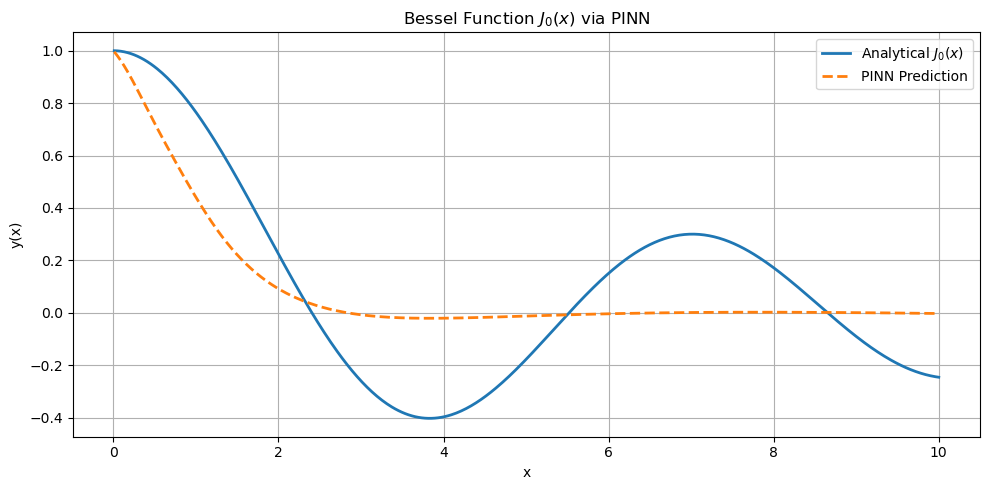

In [94]:
# -----------------------------
# Plotting the Results
# -----------------------------

plt.figure(figsize=(10, 5))  # Set the figure size

# Plot the analytical solution
plt.plot(x_test, y_true, label="Analytical $J_0(x)$", linewidth=2)

# Plot the predicted solution from the PINN model
plt.plot(x_test, y_pred, '--', label="PINN Prediction", linewidth=2)

# Set axis labels and title
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("Bessel Function $J_0(x)$ via PINN")

# Add legend and grid for clarity
plt.legend()
plt.grid(True)

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

# Display the plot
plt.show()


## Conclusion
- The Physics-Informed Neural Network (PINN) approximates the analytical solution of the Bessel differential equation.
- However, the solution struggles to accurately capture the oscillatory and damping behavior characteristic of the Bessel function.
- The use of the Tanh activation function and incorporation of boundary conditions help maintain model stability during training.
- While PINNs offer a mesh-free approach to solving ODEs, alternative strategies or network architectures may be needed to better represent complex behaviors like those of Bessel functions.